In [1]:
@time versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 96 × Intel(R) Xeon(R) Gold 5318Y CPU @ 2.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, icelake-server)
  Threads: 2 on 96 virtual cores
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


- https://turinglang.org/dev/tutorials/03-bayesian-neural-network/

In [1]:
@time using Turing
@time using FillArrays
@time using Flux
@time using Plots
@time using ReverseDiff

@time using LinearAlgebra
@time using Random

# Use reverse_diff due to the number of parameters in neural networks.
Turing.setadbackend(:reversediff)

  7.906143 seconds (4.83 M allocations: 312.916 MiB, 2.29% gc time, 16.54% compilation time: 87% of which was recompilation)
  0.186165 seconds (80.18 k allocations: 5.647 MiB, 99.91% compilation time: 100% of which was recompilation)
  1.618405 seconds (996.89 k allocations: 62.176 MiB, 3.13% gc time, 3.62% compilation time)
  7.377111 seconds (5.75 M allocations: 328.853 MiB, 3.16% gc time, 12.20% compilation time: 99% of which was recompilation)
  9.581202 seconds (14.16 M allocations: 950.961 MiB, 2.08% gc time, 0.21% compilation time)
  0.007226 seconds (272 allocations: 28.641 KiB)
  0.007506 seconds (279 allocations: 28.844 KiB)


:reversediff

# Simulate data and plot

  0.241836 seconds (259.15 k allocations: 14.564 MiB, 99.75% compilation time)
  0.240828 seconds (260.10 k allocations: 14.609 MiB, 99.72% compilation time)
  0.123375 seconds (109.58 k allocations: 7.252 MiB, 97.12% compilation time)


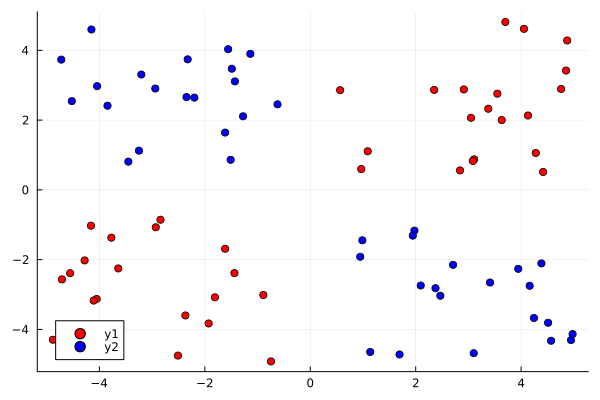

In [27]:
# Number of points to generate.
N = 80
M = round(Int, N / 4)
Random.seed!(1234)

# Generate artificial data.
x1s = rand(M) * 4.5;
x2s = rand(M) * 4.5;
xs_t1 = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i in 1:M])

x1s = rand(M) * 4.5;
x2s = rand(M) * 4.5;
@time append!(xs_t1, Array([[x1s[i] - 5; x2s[i] - 5] for i in 1:M]))

x1s = rand(M) * 4.5;
x2s = rand(M) * 4.5;
xs_t0 = Array([[x1s[i] + 0.5; x2s[i] - 5] for i in 1:M])

x1s = rand(M) * 4.5;
x2s = rand(M) * 4.5;
@time append!(xs_t0, Array([[x1s[i] - 5; x2s[i] + 0.5] for i in 1:M]))

# Store all the data for later.
xs = [xs_t1; xs_t0]
# a vector of classes for all data
ts = [ones(2 * M); zeros(2 * M)]

# Plot data points.
function plot_data()
    x1 = map(e -> e[1], xs_t1)
    y1 = map(e -> e[2], xs_t1)
    x2 = map(e -> e[1], xs_t0)
    y2 = map(e -> e[2], xs_t0)

    Plots.scatter(x1, y1; color="red", clim=(0, 1))
    return Plots.scatter!(x2, y2; color="blue", clim=(0, 1))
end

@time plot_data()

In [25]:
@show size(xt1s)
@show first(xt1s,3)
@show size(xt0s)
@show size(xs)
@show typeof(xs)
@show first(xs, 3)
@show size(ts)
@show typeof(ts)

size(xt1s) = (40,)
first(xt1s, 3) = [[3.109379540603596, 0.875480402444553], [2.3508235307743273, 2.8660804874110517], [4.874612371049609, 4.282884137652053]]
size(xt0s) = (40,)
size(xs) = (80,)
typeof(xs) = Vector{Vector{Float64}}
first(xs, 3) = [[3.109379540603596, 0.875480402444553], [2.3508235307743273, 2.8660804874110517], [4.874612371049609, 4.282884137652053]]
size(ts) = (80,)
typeof(ts) = Vector{Float64}


Vector{Float64} (alias for Array{Float64, 1})

In [24]:
@show [ones(2), zeros(2)]
@show [ones(2); zeros(2)]

[ones(2), zeros(2)] = [[1.0, 1.0], [0.0, 0.0]]
[ones(2); zeros(2)] = [1.0, 1.0, 0.0, 0.0]


4-element Vector{Float64}:
 1.0
 1.0
 0.0
 0.0

# Construct a neural network using Flux


In [3]:
nn_initial = Chain(Dense(2, 3, tanh), Dense(3, 2, tanh), Dense(2, 1, σ))

# Extract weights and a helper function to reconstruct NN from weights
parameters_initial, reconstruct = Flux.destructure(nn_initial)

length(parameters_initial) # number of paraemters in NN

20

## What is Flux.destructure()

In [18]:
?Flux.destructure

```
destructure(model) -> vector, reconstructor
```

Copies all [`trainable`](@ref), [`isnumeric`](@ref) parameters in the model to a vector, and returns also a function which reverses this transformation. Differentiable.

# Example

```jldoctest
julia> v, re = destructure((x=[1.0, 2.0], y=(sin, [3.0 + 4.0im])))
(ComplexF64[1.0 + 0.0im, 2.0 + 0.0im, 3.0 + 4.0im], Restructure(NamedTuple, ..., 3))

julia> re([3, 5, 7+11im])
(x = [3.0, 5.0], y = (sin, ComplexF64[7.0 + 11.0im]))
```

If `model` contains various number types, they are promoted to make `vector`, and are usually restored by `Restructure`. Such restoration follows the rules  of `ChainRulesCore.ProjectTo`, and thus will restore floating point precision, but will permit more exotic numbers like `ForwardDiff.Dual`.

If `model` contains only GPU arrays, then `vector` will also live on the GPU. At present, a mixture of GPU and ordinary CPU arrays is undefined behaviour.


In [17]:
@show reconstruct

Restructure(Chain, ..., 20)

In [4]:
@model function bayes_nn(xs, ts, nparameters, reconstruct; alpha=0.09)
    # Create the weight and bias vector.
    parameters ~ MvNormal(Zeros(nparameters), I / alpha)

    # Construct NN from parameters
    nn = reconstruct(parameters)
    # Forward NN to make predictions
    preds = nn(xs)

    # Observe each prediction.
    for i in 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end;

In [33]:
xs_tmp1 = hcat(xs'...)
@show size(xs_tmp1)
xs_tmp2 = hcat(xs...)
@show size(xs_tmp2)

size(xs_tmp1) = (1, 160)
size(xs_tmp2) = (2, 80)


(2, 80)

# MCMC sample

In [45]:
# Perform inference.
no_of_iters = 5000
@time ch = sample(bayes_nn(hcat(xs...), ts, length(parameters_initial), reconstruct), NUTS(), no_of_iters);

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:50:18


3044.056851 seconds (46.18 G allocations: 1.859 TiB, 24.61% gc time)


In [35]:
ch

Chains MCMC chain (5000×32×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 2601.34 seconds
Compute duration  = 2601.34 seconds
parameters        = parameters[1], parameters[2], parameters[3], parameters[4], parameters[5], parameters[6], parameters[7], parameters[8], parameters[9], parameters[10], parameters[11], parameters[12], parameters[13], parameters[14], parameters[15], parameters[16], parameters[17], parameters[18], parameters[19], parameters[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
      parameters      mean       std      mcse   ess_bulk    ess_tail      rha ⋯
          Symbol   Float64   Float64   Float64    Float64     Float64   Float6 ⋯

   parameters[1]    0.2762    3.7604    0.3808    99.4106    466.8496    1.000 ⋯
 

In [6]:
# Extract all weight and bias parameters.
theta = MCMCChains.group(ch, :parameters).value;

In [11]:
theta

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 1001:1:6000
    :var, [Symbol("parameters[1]"), Symbol("parameters[2]"), Symbol("parameters[3]"), Symbol("parameters[4]"), Symbol("parameters[5]"), Symbol("parameters[6]"), Symbol("parameters[7]"), Symbol("parameters[8]"), Symbol("parameters[9]"), Symbol("parameters[10]"), Symbol("parameters[11]"), Symbol("parameters[12]"), Symbol("parameters[13]"), Symbol("parameters[14]"), Symbol("parameters[15]"), Symbol("parameters[16]"), Symbol("parameters[17]"), Symbol("parameters[18]"), Symbol("parameters[19]"), Symbol("parameters[20]")]
    :chain, 1:1
And data, a 5000×20×1 Array{Float64, 3}:
[:, :, 1] =
 1.81553  -0.298891    1.82056    …  5.30553  5.20645  -5.7778   4.46604
 5.81109  -0.0536664   3.07836       6.92876  6.27945  -6.47568  3.35612
 4.63501   0.926425   -1.20759       6.08919  6.91316  -5.60484  3.69858
 4.47387  -0.149593    0.217029      5.91025  5.00067  -5.95597  4.77707
 4.59702   0.163756   -0.432468      7.05109

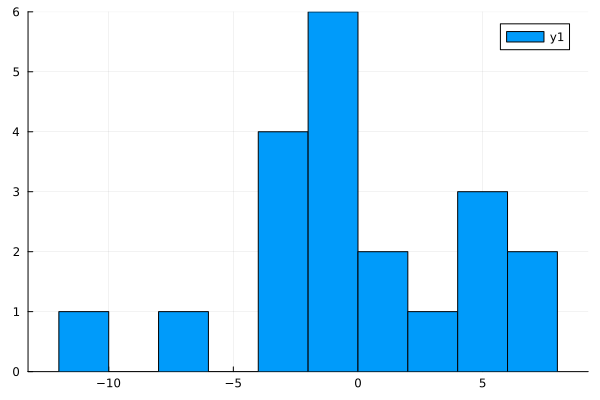

In [53]:
histogram(theta[1288, :,:], bins=15)

## what is findmax()

In [37]:
?findmax

search: findmax findmax! findmin findmin!



```
findmax(f, domain) -> (f(x), index)
```

Return a pair of a value in the codomain (outputs of `f`) and the index of the corresponding value in the `domain` (inputs to `f`) such that `f(x)` is maximised. If there are multiple maximal points, then the first one will be returned.

`domain` must be a non-empty iterable.

Values are compared with `isless`.

!!! compat "Julia 1.7"
    This method requires Julia 1.7 or later.


# Examples

```jldoctest
julia> findmax(identity, 5:9)
(9, 5)

julia> findmax(-, 1:10)
(-1, 1)

julia> findmax(first, [(1, :a), (3, :b), (3, :c)])
(3, 2)

julia> findmax(cos, 0:π/2:2π)
(1.0, 1)
```

---

```
findmax(itr) -> (x, index)
```

Return the maximal element of the collection `itr` and its index or key. If there are multiple maximal elements, then the first one will be returned. Values are compared with `isless`.

See also: [`findmin`](@ref), [`argmax`](@ref), [`maximum`](@ref).

# Examples

```jldoctest
julia> findmax([8, 0.1, -9, pi])
(8.0, 1)

julia> findmax([1, 7, 7, 6])
(7, 2)

julia> findmax([1, 7, 7, NaN])
(NaN, 4)
```

---

```
findmax(A; dims) -> (maxval, index)
```

For an array input, returns the value and index of the maximum over the given dimensions. `NaN` is treated as greater than all other values except `missing`.

# Examples

```jldoctest
julia> A = [1.0 2; 3 4]
2×2 Matrix{Float64}:
 1.0  2.0
 3.0  4.0

julia> findmax(A, dims=1)
([3.0 4.0], CartesianIndex{2}[CartesianIndex(2, 1) CartesianIndex(2, 2)])

julia> findmax(A, dims=2)
([2.0; 4.0;;], CartesianIndex{2}[CartesianIndex(1, 2); CartesianIndex(2, 2);;])
```

---

```
findmax(f, A; dims) -> (f(x), index)
```

For an array input, returns the value in the codomain and index of the corresponding value which maximize `f` over the given dimensions.

# Examples

```jldoctest
julia> A = [-1.0 1; -0.5 2]
2×2 Matrix{Float64}:
 -1.0  1.0
 -0.5  2.0

julia> findmax(abs2, A, dims=1)
([1.0 4.0], CartesianIndex{2}[CartesianIndex(1, 1) CartesianIndex(2, 2)])

julia> findmax(abs2, A, dims=2)
([1.0; 4.0;;], CartesianIndex{2}[CartesianIndex(1, 1); CartesianIndex(2, 2);;])
```


# Plot the MAP preditions

i = CartesianIndex(1288, 1)
i = 1288
  0.087142 seconds (104.99 k allocations: 5.870 MiB, 84.67% compilation time)
  0.000681 seconds (323 allocations: 58.219 KiB)


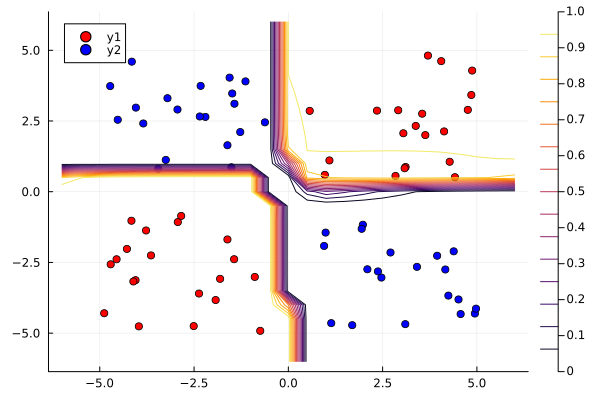

In [52]:
# A helper to create NN from weights `theta` and run it through data `x`
nn_forward(x, theta) = reconstruct(theta)(x)

# Plot the raw data
plot_data()

# Find the index that provided the highest log posterior in the chain.
_, i = findmax(ch[:lp])

@show i

# Extract the max row value from i.
i = i.I[1]
@show i

# Plot the posterior distribution with a contour plot
x1_range = collect(range(-6; stop=6, length=25))
x2_range = collect(range(-6; stop=6, length=25))
@time Z = [nn_forward([x1, x2], theta[i, :])[1] for x1 in x1_range, x2 in x2_range]
#@time plot!(x1_range, x2_range, Z)
@time contour!(x1_range, x2_range, Z)

## What is nn_forward?

In [36]:
?nn_forward

search: nn_forward



No documentation found.

`nn_forward` is a `Function`.

```
# 1 method for generic function "nn_forward" from Main:
 [1] nn_forward(x, theta)
     @ In[7]:2
```


# Plot the averaged predictions

In [8]:
# Return the average predicted value across
# multiple weights.
function nn_predict(x, theta, num)
    return mean([nn_forward(x, theta[i, :])[1] for i in 1:10:num])
end;

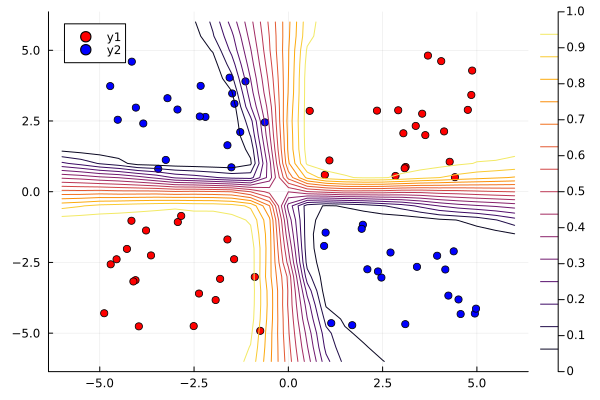

In [54]:
# Plot the average prediction.
plot_data()

n_end = 1500
x1_range = collect(range(-6; stop=6, length=25))
x2_range = collect(range(-6; stop=6, length=25))
Z = [nn_predict([x1, x2], theta, n_end)[1] for x1 in x1_range, x2 in x2_range]
contour!(x1_range, x2_range, Z)

# Plot the predictions as the model evolves

[ Info: Saved animation to /home/huang.yu/src/julia-prob-programming/tmp.gif


Plots.AnimatedGif("/home/huang.yu/src/julia-prob-programming/tmp.gif")
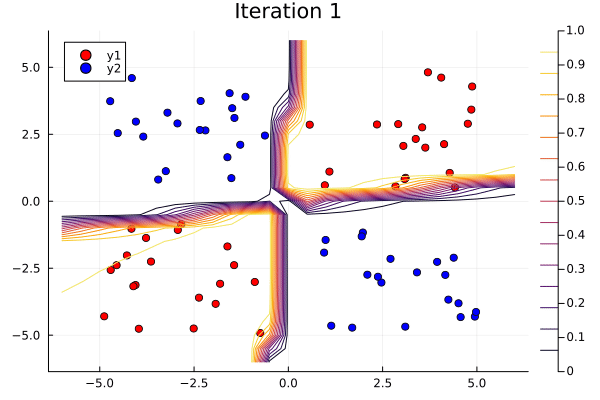

In [46]:
anim = @gif for i in 1:20:no_of_iters
    plot_data()
    Z = [nn_forward([x1, x2], theta[i, :])[1] for x1 in x1_range, x2 in x2_range]
    contour!(x1_range, x2_range, Z; title="Iteration $i", clim=(0, 1))
end every 5